# Time series forecasting

**Goal:** A company needs to set up a new warehouse. For this matter, we will estimate the rate of sales of the company for the next few months in order to provide an accurate figure for the space they will need.

-----------------------------------------------------------------------------

**Step 1:** Loading the dataset nad reviewing the structure.

In [23]:
import pandas as pd

raw_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")

raw_data.head(366)

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


Will do a general review of the data quality: diension (r & c), missing data, zeros.

In [21]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [22]:
# Check for missing data
print("Missing Data:")
print(raw_data.isnull().sum())

Missing Data:
date     0
sales    0
dtype: int64


In [23]:
# Check for zeros in numerical columns
print("\nZeros in Numerical Columns:")
print((raw_data == 0).sum())


Zeros in Numerical Columns:
date     0
sales    0
dtype: int64


In [24]:
# Basic summary statistics for the dataset
print("\nSummary Statistics:")
print(raw_data.describe())


Summary Statistics:
             sales
count   366.000000
mean    524.963968
std     275.089698
min      53.803211
25%     290.186822
50%     520.699468
75%     763.289263
max    1000.482785


The dataset is full and complete. Now we can proceed with the data adaptation for the ARIMA.

**Step 2:** Construct and analyze the time serie

To apply the ARIMA model, we need to prepare the raw data set and convert it into a **two dimensional time series'.

In [25]:
# Converting the 'date' column to a datetime format:

raw_data["date"] = pd.to_datetime(raw_data["date"])

# Set the 'date' column as the index
raw_data = raw_data.set_index("date")

# Extract the 'sales' column as the time series
time_set = raw_data["sales"]

# Display the first few rows of the new time series
print(time_set.head())

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64


Next, we will visualize the time series to perform a visual analysis of it:

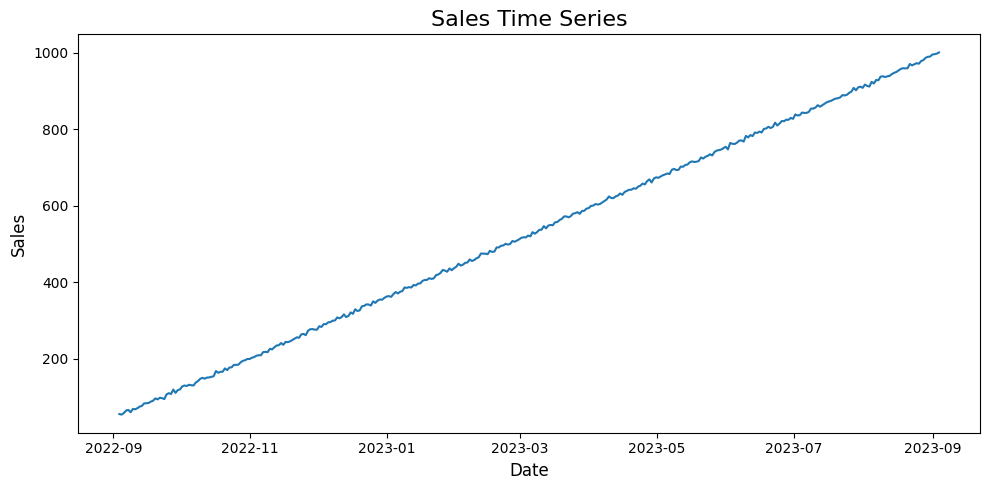

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the time series
fig, axis = plt.subplots(figsize=(10, 5))

sns.lineplot(data=time_set, ax=axis)

# Add labels and title
axis.set_title("Sales Time Series", fontsize=16)
axis.set_xlabel("Date", fontsize=12)
axis.set_ylabel("Sales", fontsize=12)

plt.tight_layout()
plt.show()

Now we should be able to answer the following questions:

**Which is the tensor of the time serie?**

In time series analysis, a <ins>Tensor is:</ins>

- The shape and dimensionality of the data. In time series usualy 1D.

The definition of <ins>Tensor IS NOT:</ins>

- The minimum unit of time for which there is data. This is called the <ins>time interval or granularity</ins> of the time series, <ins>not the tensor.</ins>


Once clarified this, gicen our dataset is 1D and the increment is 1 day (diference in data entries), it would be **1 day**. Demonstrated in the following code:


In [27]:
# One dimensional array:

print(time_set.shape)

(366,)


In [28]:
# Time increments:

print(time_set.index.to_series().diff().mode())

0   1 days
Name: date, dtype: timedelta64[ns]


**Which is the trend?**

Now lets evidence this with graphs representation:

The trend is a positive slop line, indicatin a growing sales along time:

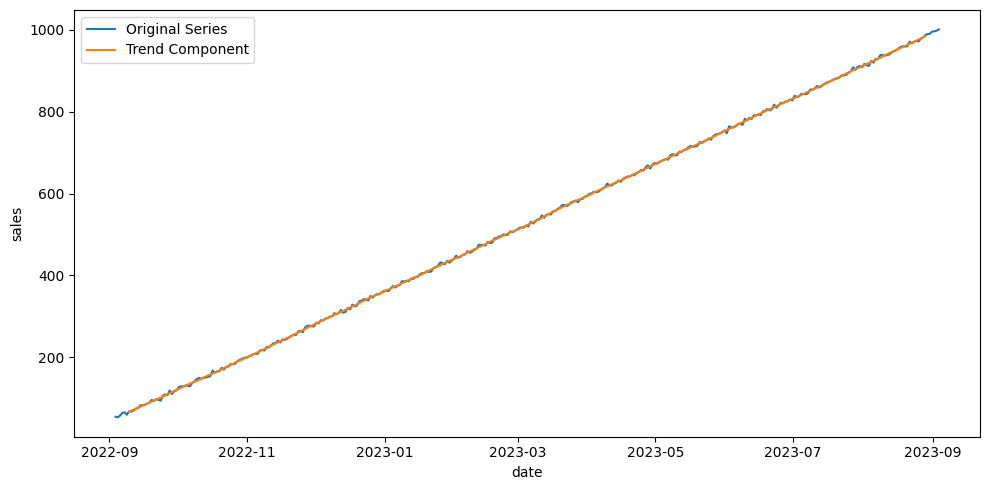

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt

# Decomposing the time series with an assumed period (e.g., 12 for monthly seasonality)
decomposition = seasonal_decompose(time_set, period=12)
trend = decomposition.trend

# Plotting the original time series and the trend component
fig, axis = plt.subplots(figsize=(10, 5))
sns.lineplot(data=time_set, label="Original Series", ax=axis)
sns.lineplot(data=trend, label="Trend Component", ax=axis)
axis.legend()

plt.tight_layout()
plt.show()

**Seasonality:** There is not a seasonal cyclic alteratoin of the values.

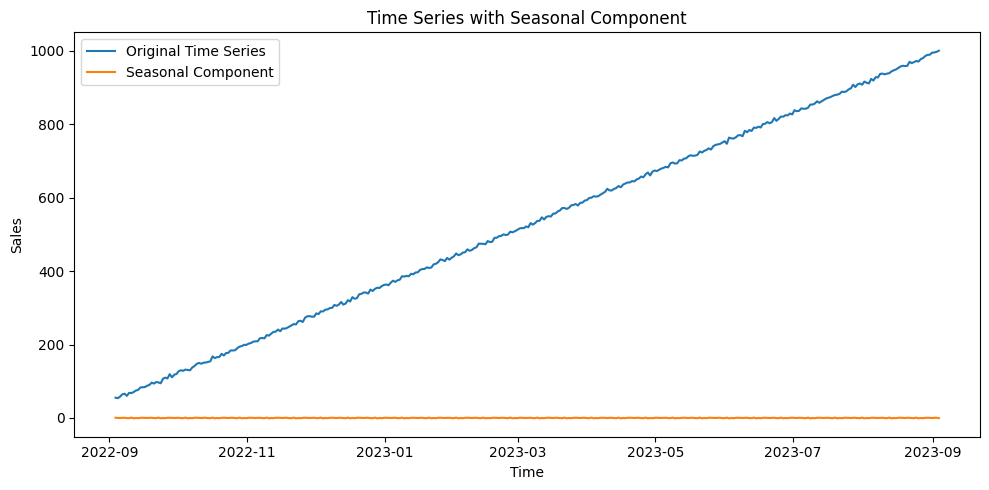

In [30]:
# Checking for seasonal behavior of the data:

seasonal = decomposition.seasonal

# Plotting the time series with the seasonal component:
fig, axis = plt.subplots(figsize=(10, 5))

sns.lineplot(data=time_set, label="Original Time Series")
sns.lineplot(data=seasonal, label="Seasonal Component")

plt.title("Time Series with Seasonal Component")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()

plt.show()

**Stacionarity:** To evaluate the stationarity of the data we have to apply the **Dickey-Fuller test.**
This test is hypothesis test in which <ins>the null hypothesis is that the series is stationary, and the alternative is that it is non-stationary</ins>:

In [31]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

# Perform the test on the time series
dickey_fuller_results = test_stationarity(time_set)

print(dickey_fuller_results)

# Interpret the results
if dickey_fuller_results["p-value"] < 0.05:
    print("\nThe null hypothesis is rejected. The series is stationary.")
else:
    print("\nThe null hypothesis cannot be rejected. The series is non-stationary.")

Dickey-Fuller test results:
Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

The null hypothesis cannot be rejected. The series is non-stationary.


**Conclusion:**

Test Statistic: Value of the test statistic from the Dickey-Fuller test.
p-value: Determines if the null hypothesis can be rejected.

Critical Values: Reference values at 1%, 5%, and 10% levels to compare the test statistic.
Hypothesis Interpretation:

If p-value < 0.05, the series is stationary.
If p-value >= 0.05, the series is non-stationary.

In our case **p-value = 0,9861**, hence the time series is **NON-STATIONARY**.

A series is stationary when it is stable over time, that is, when the mean and variance are constant over time. In this case, our dataset is **NON STATIONARY.**

Test Statistic and Critical Values:

The Test Statistic value is likely higher (closer to zero) than the critical values at the 1%, 5%, and 10% significance levels. This further supports that the time series is non-stationary.
Conclusion:

The data shows a trend or seasonality, so <ins>transformations or differencing will be required to make it stationary before proceeding with ARIMA modeling.</ins>

**Variability or noise:** The trend is very steady and no big variability is found. However will see the graph.

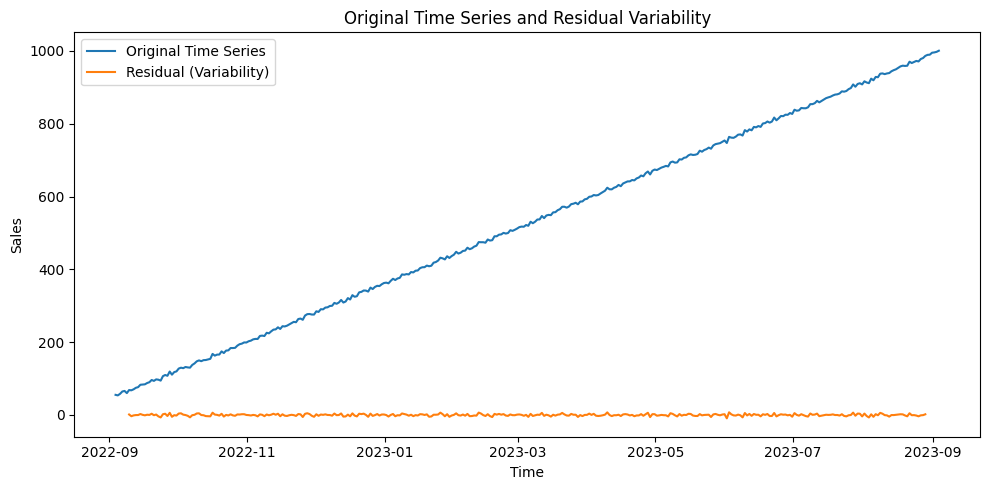

In [32]:
# Extract the residual component
residual = decomposition.resid

# Plot the original time series and the residuals
fig, axis = plt.subplots(figsize=(10, 5))

sns.lineplot(data=time_set, label="Original Time Series")
sns.lineplot(data=residual, label="Residual (Variability)")

plt.title("Original Time Series and Residual Variability")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

The residual plot shows very regular patterns, hence the series don't require more processing (e.g., differencing).

**Outliers:** Studying the trend and seasonality of the time series, no outliers are observed in the time series.

**Inflection points:** No inflection point found. Very steady linear growth. <ins>The dataset seems to adapt almost perfectly to a linear y = x regression.</ins>

**Autocorrelation analysis**

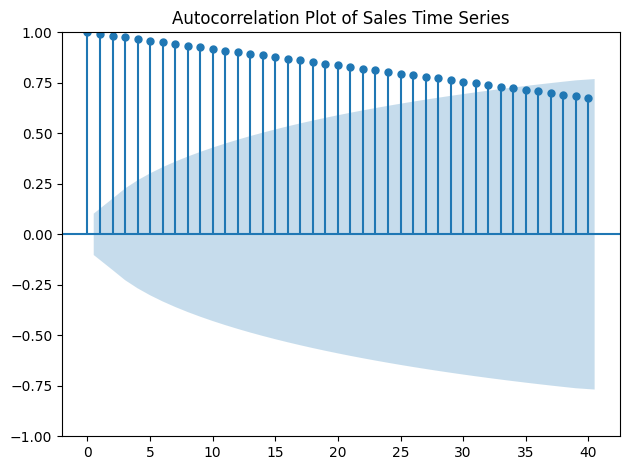

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plot the autocorrelation of the time series:

plot_acf(time_set, lags=40)  #<---------------------- We can adjust lags for more or fewer observations

plt.title("Autocorrelation Plot of Sales Time Series")
plt.tight_layout()
plt.show()

Gradual Decline: The autocorrelation gradually decreases, this indicates a trend in the data.

Peaks: Regular peaks suggest seasonality in the time series.

In general terms the graph indicates a great correlation of the time series with previous values, decresing slightly overtime.

 **Step 3:** Train an ARIMA model finding the best parameterization of the model.


The first thing we have to consider is that in order to optimize its results to the maximum, <ins>we must transform the series into stationary.</ins>

In [34]:
# Transforming the dataset into stationary by differencing
time_set_stationary = time_set.diff().dropna()

# Reusing the test_stationarity function to check the new series
stationarity_results = test_stationarity(time_set_stationary)
stationarity_results

Dickey-Fuller test results:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

Now the series is stationary, and we can apply the automatic ARIMA method:

In [35]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model
model = ARIMA(time_set_stationary, order=(1, 1, 1))
results = model.fit()

# Print the model summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -983.676
Date:                Tue, 10 Dec 2024   AIC                           1973.353
Time:                        13:23:42   BIC                           1985.044
Sample:                    09-04-2022   HQIC                          1977.999
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5417      0.045    -11.923      0.000      -0.631      -0.453
ma.L1         -0.9999      3.708     -0.270      0.787      -8.268       6.268
sigma2        12.7754     47.344      0.270      0.7

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


**Step 4:** Predicting with the test set.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

# Forecast the next XX steps
forecast_steps = 180
forecast_object = results.get_forecast(steps=forecast_steps)

# Extract forecasted mean values
forecast = forecast_object.predicted_mean

# Create a datetime index for the forecast
forecast_index = pd.date_range(start=time_set.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq="D")
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Undo differencing to bring forecasts back to the original scale
forecast_final = forecast_series.cumsum() + time_set.iloc[-1]

# Print the forecasted values
print(forecast_final)

2023-09-04 17:10:08.079328    1002.783473
2023-09-05 17:10:08.079328    1005.534774
2023-09-06 17:10:08.079328    1008.041989
2023-09-07 17:10:08.079328    1010.681420
2023-09-08 17:10:08.079328    1013.249232
                                 ...     
2024-02-26 17:10:08.079328    1456.656917
2024-02-27 17:10:08.079328    1459.249892
2024-02-28 17:10:08.079328    1461.842868
2024-02-29 17:10:08.079328    1464.435844
2024-03-01 17:10:08.079328    1467.028819
Freq: D, Length: 180, dtype: float64


Instead of predict, I ahve used 'get_forecast' because the statsmodels de ARIMA does not provide 'predict' shortcut.

Also, this method generates not only the forecasted mean values but <ins>also confidence intervals and diagnostic information.</ins>

It gives more flexibility and control over the results, which is useful for proper analysis and visualization.

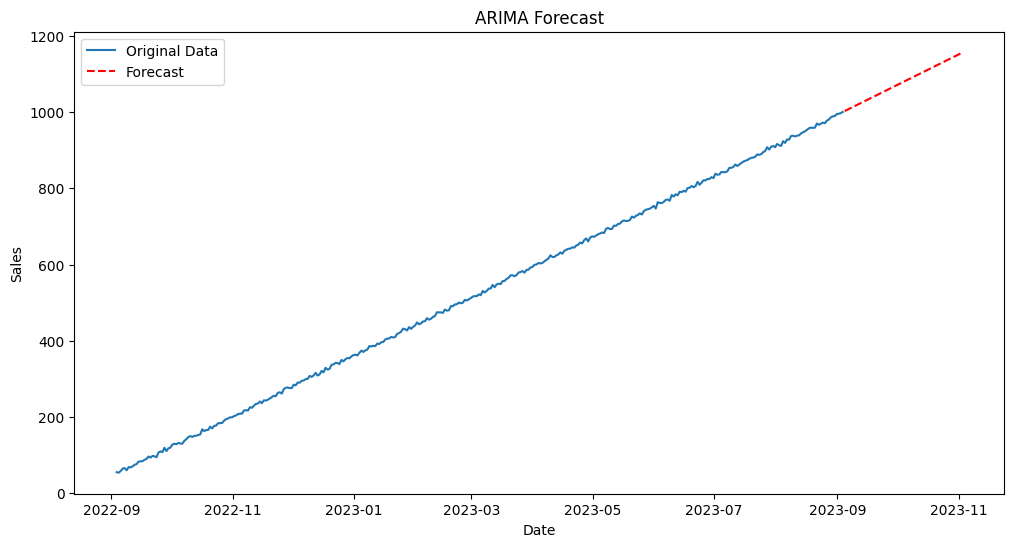

In [26]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the original time series
sns.lineplot(x=time_set.index, y=time_set.values, label="Original Data", ax=ax)

# Plot the forecast
sns.lineplot(x=forecast_final.index, y=forecast_final.values, label="Forecast", ax=ax, color="red", linestyle="--")

plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Prediction final result

I has been provided an estimation of he company sales volume at 30 days, 60 days, 90 days and 180 days:

Nowadays: 1000.48 units sales

30 days: 1078.08 units sales

60 days: 1155.87 units sales

90 days: 1233.66 units sales

180 days: 1467.03 units sales

**With this information, the company can develop the warehouse construciton proyect and adapt the dimensios of it to the future company storage necessities.**

Now will save the model:

In [29]:
import pickle

# Save the ARIMA model to a file
with open("arima_model.pkl", "wb") as model_file:
    pickle.dump(results, model_file)

print("Model saved successfully!")

Model saved successfully!
